## Import

In [1]:
import pandas as pd
import numpy as np
import random
import os
from time import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from fasttext import load_model
import math
from PIL import Image
from functools import partial
import cv2

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
import lightgbm as lgb

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from timm.models import resnet50
from timm.models.efficientnet import tf_efficientnet_b0_ns
from albumentations import (
    Compose, OneOf, Normalize, Resize, RandomResizedCrop, RandomCrop, HorizontalFlip, VerticalFlip,
    RandomBrightness, RandomContrast, RandomBrightnessContrast, Rotate, ShiftScaleRotate, Cutout,
    IAAAdditiveGaussianNoise, Transpose, 
)
from albumentations.pytorch import ToTensorV2

## Settings

In [2]:
DATA_PATH = "/home/knikaido/work/atma10/data/"
IMG_DIR = DATA_PATH + "img/"
TRAIN_PATH = DATA_PATH + "train.csv"
TEST_PATH = DATA_PATH + "test.csv"
SUB_PATH = DATA_PATH + "atmacup10__sample_submission.csv"

In [3]:
SEED = 42
N_SPLITS = 5
SHUFFLE = True
EPOCH = 50
OUTPUT_DIR = './output/'

DATASET_CONFIG = {
    'loader': {
      'train': {
        'batch_size': 16,
        'shuffle': True,
        'num_workers': 1,
        'pin_memory': True,
        'drop_last': True,
      },
      'valid': {
        'batch_size': 2,
        'shuffle': False,
        'num_workers': 1,
        'pin_memory': True,
        'drop_last': True,
      }
    }
}

config = DATASET_CONFIG
SAVE_TEST_SUB_PATH = "sub05.csv"

## Utility

In [4]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
set_seed(SEED)

## Feature Engineering

In [5]:
train = pd.read_csv(TRAIN_PATH)
palette_df = pd.read_csv(DATA_PATH + 'palette.csv')
palette_df_all = palette_df.merge(train, how='inner', on='object_id').sort_values(['object_id'])
df_id = pd.Series(palette_df_all['object_id'].unique())
df_id.name = 'object_id'
train = pd.merge(df_id, train, how='left', on='object_id')

test = pd.read_csv(TEST_PATH)
palette_df_all = palette_df.merge(test, how='inner', on='object_id').sort_values(['object_id'])
df_id = pd.Series(palette_df_all['object_id'].unique())
df_id.name = 'object_id'
test = pd.merge(df_id, test, how='left', on='object_id')

len_train = len(train)

y = np.log1p(train["likes"])
train

,object_id,art_series_id,title,description,long_title,principal_maker,principal_or_first_maker,sub_title,copyright_holder,more_title,acquisition_method,acquisition_date,acquisition_credit_line,dating_presenting_date,dating_sorting_date,dating_period,dating_year_early,dating_year_late,likes
0,0011d6be41612ec9eae3,93c092ba70beab248f31,The Avenue of Birches,NaN,"The Avenue of Birches, Jan Hackaert, 1660 - 1685",Jan Hackaert,Jan Hackaert,h 66.5cm × w 53.7cm × t 2.5cm × d 4.7cm,NaN,The Avenue of Birches,purchase,1808-01-01T00:00:00,NaN,1660 - 1685,1660.0,17,1660.0,1685.0,48
1,0012765f7a97ccc3e9e9,95c14fb11c54281ad7e0,Struik in bloei,NaN,"Struik in bloei, Richard Tepe (attributed to),...",Richard Tepe,Richard Tepe,h 165mm × w 223mm,erven Richard Tepe,Struik in bloei,purchase,2000-01-01T00:00:00,NaN,c. 1900 - c. 1930,1900.0,19,1900.0,1930.0,2
2,00181d86ff1a7b95864e,fa0891535500a4973db2,A St Bernard Dog,"Een sint-bernardshond, staand in een landschap...","A St Bernard Dog, Bernard te Gempt, c. 1850 - ...",Bernard te Gempt,Bernard te Gempt,h 179cm × w 248cm × t 4cm,NaN,A St Bernard Dog,bequest,1881-01-01T00:00:00,"J. Hilman Bequest, Amsterdam",c. 1850 - c. 1879,1850.0,19,1850.0,1879.0,100
3,001c52ae28ec106d9cd5,8065ed5063c5887e677d,Woelige zee met zeilschepen,Woelige zee met zeilschepen.,"Woelige zee met zeilschepen, anonymous, 1825 -...",anonymous,anonymous,h 13cm × w 17.5cm × d 0.7cm,NaN,Woelige zee met zeilschepen,unknown,1971-01-01T00:00:00,NaN,1825 - 1874,1825.0,19,1825.0,1874.0,7
4,001f4c71b4d53497b531,63b35be23b58a65e564d,Personificatie van de zedigheid,Een vrouwfiguur als personificatie van de zedi...,"Personificatie van de zedigheid, C.A. Tuchs, 1867",C.A. Tuchs,C.A. Tuchs,h 228mm × w 131mm,NaN,Personificatie van de zedigheid,gift,1933-01-01T00:00:00,"Gift of the Ministerie van Onderwijs, Kunsten ...",1867,1867.0,19,1867.0,1867.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12002,ffedf8af4fd5b3873164,2e4695e7f3260d52b3e6,De schilder H.W. Mesdag voor een doek,NaN,"De schilder H.W. Mesdag voor een doek, Delboy ...",Delboy & Baer,Delboy & Baer,h 90mm × w 140mm,NaN,De schilder H.W. Mesdag voor een doek H W Mesdag,transfer,1994-01-01T00:00:00,NaN,1900 - 1920,1900.0,19,1900.0,1920.0,4
12003,ffee34705ea44e1a0f79,7aa656a9ef243d93d009,"Kaart van de streek tussen Mannheim en Landau,...","Kaart van de streek tussen Mannheim, Speyer en...","Kaart van de streek tussen Mannheim en Landau,...",Abraham Allard,Abraham Allard,h 245mm × w 278mm,NaN,"Kaart van de streek tussen Mannheim en Landau,...",purchase,1881-01-01T00:00:00,NaN,1701 - 1714,1701.0,18,1701.0,1714.0,0
12004,ffefbe1faf771aa4f790,e79c2e74ed17533a7e56,Storm op het IJ aan het Blauwhoofd van Amsterd...,Zeilschepen in de problemen op het IJ ter hoog...,Storm op het IJ aan het Blauwhoofd van Amsterd...,Noach van der Meer (II),Noach van der Meer (II),h 217mm × w 306mm,NaN,Storm op het IJ aan het Blauwhoofd van Amsterd...,transfer,1887-01-01T00:00:00,NaN,1778,1778.0,18,1778.0,1778.0,0
12005,fff08e76cbb969eaddc7,510358b74c1104edbbbd,"Het rad van fortuin, ca. 1689","Het rad van fortuin, ca. 1689. Spotprent op de...","Het rad van fortuin, ca. 1689, Romeyn de Hoogh...",Romeyn de Hooghe,Romeyn de Hooghe,h 560mm × w 405mm,NaN,"Het rad van fortuin, ca. 1689 'T Hedendaags Ra...",purchase,1881-01-01T00:00:00,NaN,1689 - 1690,1689.0,17,1689.0,1690.0,14


In [6]:
def get_transforms(img_size=224, data=None):
    if data == 'train':
        return Compose([
            Resize(img_size, img_size),
            # RandomResizedCrop(img_size, img_size, scale=(0.85, 1.0)),
            # HorizontalFlip(p=0.5),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return Compose([
            Resize(img_size, img_size),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

In [7]:
class ImageDataset(data.Dataset):
    def __init__(
        self,
        train_df,
        transform=None,
    ):      
        self.train_df = train_df
        self.transform = transform

    def __len__(self):
        return len(self.train_df)

    def __getitem__(self, idx: int):
        
        img_path = self.train_df['object_id'][idx]
        img_path = IMG_DIR + img_path + 'png.png'
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=img)
            img = augmented['image']
        
        likes = np.log1p(self.train_df['likes'][idx]).astype(np.float32)

        return img, likes

In [8]:
class LitModule(pl.LightningModule):
    
    def __init__(self):
        super().__init__()

        self.encoder = partial(tf_efficientnet_b0_ns, pretrained=True, in_chans=3, num_classes=1)()
        self.criterion = nn.MSELoss()
        
    def forward(self, x):
               
        x = self.encoder(x)

        return x
    
    def configure_optimizers(self):
#         optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
#         return optimizer
        optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=True)
        scheduler = {'scheduler': torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=0.001*0.01),
                                'name': 'learning_rate',
                                'interval':'epoch',
                                'frequency': 1}

        return [optimizer], [scheduler]
    
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        y_pred = self.forward(x)
        loss = torch.sqrt(self.criterion(y_pred, y.reshape(-1)))
        self.log('train_loss', loss,  on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        y_pred = self.forward(x)
        loss = torch.sqrt(self.criterion(y_pred, y.reshape(-1)))
        return loss

    def validation_epoch_end(self, validation_step_outputs):
        validation_step_outputs = np.array(validation_step_outputs)
#         validation_step_losses = validation_step_outputs[:, 0]
        mean_loss = torch.stack([x for x in validation_step_outputs]).mean()

        print('valid_epoch_loss = ', mean_loss)
        self.log('valid_epoch_loss', mean_loss, prog_bar=True, logger=True)
        return mean_loss,

In [9]:
kf = KFold(n_splits=N_SPLITS,random_state=SEED, shuffle=SHUFFLE)

for fold_id, (train_index, val_index) in enumerate(kf.split(train)):

    train_data = train.iloc[train_index]
    valid_data = train.iloc[val_index]   
    
    train_data.reset_index(inplace=True, drop=True)
    valid_data.reset_index(drop=True, inplace=True)
    
    train_dataset = ImageDataset(train_data, transform=get_transforms(224, data="train"))
    valid_dataset = ImageDataset(valid_data, transform=get_transforms(224, data="valid"))
    
    train_loader = data.DataLoader(train_dataset, **config["loader"]["train"])
    valid_loader = data.DataLoader(valid_dataset, **config["loader"]["valid"])

    model = LitModule()

    trainer = pl.Trainer(
        max_epochs=EPOCH,
        default_root_dir=OUTPUT_DIR,
        gpus=1,
        deterministic=True,
        benchmark=True
    )
    trainer.fit(model, train_loader, valid_loader)
        

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name      | Type         | Params
-------------------------------------------
0 | encoder   | EfficientNet | 4.0 M 
1 | criterion | MSELoss      | 0     
-------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.035    Total estimated model params size (MB)
/home/user/.local/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Validation sanity check: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.8597, device='cuda:0')


/home/user/.local/lib/python3.6/site-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/user/.local/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The validation_epoch_end should not return anything as of 9.1. To log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)
/home/user/.local/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn

Training: 0it [00:00, ?it/s]

/home/user/.local/lib/python3.6/site-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(2.3908, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(2.1110, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.9392, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.9353, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.7849, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.7620, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.7429, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.7018, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.6818, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.6490, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.6488, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.6804, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.6259, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.6346, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5890, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.6013, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5755, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.6187, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5782, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5711, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5735, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5666, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.6125, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5822, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5744, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5605, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5648, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5594, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5637, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5718, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5626, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5520, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5330, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5391, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5601, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5385, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5446, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5526, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5598, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5370, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5649, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5579, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5456, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5432, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5605, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5517, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5360, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5383, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5317, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5293, device='cuda:0')


GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name      | Type         | Params
-------------------------------------------
0 | encoder   | EfficientNet | 4.0 M 
1 | criterion | MSELoss      | 0     
-------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.035    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.9949, device='cuda:0')


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(2.3535, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(2.1425, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.9795, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.8619, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.8133, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.7588, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.7215, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.7545, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.7000, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.7037, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.7144, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.6751, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.6722, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.6267, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.6225, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.6254, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.6207, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.6085, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.6368, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5915, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.6111, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.6130, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.6329, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.6253, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.6256, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.6104, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.6292, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.6115, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.6068, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5993, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.6107, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.6124, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.6028, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5885, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.6022, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.6475, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5900, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.6240, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5959, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5837, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5800, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.6260, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5802, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5780, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.6006, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5803, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5983, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5839, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5758, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5876, device='cuda:0')


GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name      | Type         | Params
-------------------------------------------
0 | encoder   | EfficientNet | 4.0 M 
1 | criterion | MSELoss      | 0     
-------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.035    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(2.5400, device='cuda:0')


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(2.3080, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(2.0368, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.9041, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.8257, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.7360, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.7071, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.6759, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.6479, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.6088, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.6170, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5804, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5864, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5748, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5796, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5764, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5565, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5422, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5506, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5660, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5408, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5501, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5501, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5907, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5432, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5485, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5413, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5279, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5067, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5518, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5168, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5220, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5223, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5312, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5110, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5212, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5198, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5334, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5317, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5219, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5474, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5251, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5130, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5303, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5308, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5401, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5287, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5123, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5320, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5059, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5340, device='cuda:0')


GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name      | Type         | Params
-------------------------------------------
0 | encoder   | EfficientNet | 4.0 M 
1 | criterion | MSELoss      | 0     
-------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.035    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(2.2173, device='cuda:0')


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(2.4125, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(2.1060, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.9290, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.8387, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.8247, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.7471, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.7145, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.6660, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.6540, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.6330, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.6147, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.6411, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.6524, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5926, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5542, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5883, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5726, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.6179, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5542, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5716, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5453, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5561, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5843, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5639, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5836, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5476, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5335, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5443, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5243, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5390, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5312, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5162, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5244, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5447, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5393, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5318, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5124, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5402, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5184, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5372, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5239, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5154, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5238, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5185, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5245, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5271, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5304, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5103, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5545, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5484, device='cuda:0')


GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name      | Type         | Params
-------------------------------------------
0 | encoder   | EfficientNet | 4.0 M 
1 | criterion | MSELoss      | 0     
-------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.035    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(7.3103, device='cuda:0')


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(2.4966, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(2.1928, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(2.0323, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.9174, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.8661, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.8180, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.7673, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.7466, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.7109, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.7097, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.6612, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.6583, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.6531, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.6402, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.6280, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.6155, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.6422, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.6100, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.6171, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.6143, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.6082, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.6008, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.6007, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.6036, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5982, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.6078, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.6229, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5903, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5903, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.6082, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5939, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.6023, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5985, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5896, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5844, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5875, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5855, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5898, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5843, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5848, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5904, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5758, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5920, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5811, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5837, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5727, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.6086, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5779, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5911, device='cuda:0')


Validating: 0it [00:00, ?it/s]

valid_epoch_loss =  tensor(1.5784, device='cuda:0')


In [26]:
for data_, label in train_loader:
    break

In [27]:
data_ = data_[0].to('cpu').detach().numpy().copy()
data_ = np.transpose(data_, (1, 2, 0))
plt.imshow(data_)

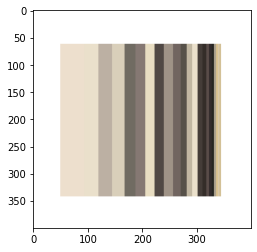